# Introduction
This project is a technical test for a Data science position.
The goal of this project is to detect fraudulent transactions in a banking dataset with two different methods.
We will use the base version of the NeurIPS 2022 dataset


# Table of contents

1. [Introduction](#introduction)
2. [Data Exploration](##data-exploration)
    * [Data distribution](##Data-distribution)
       - [target label](###fraud-label)
       - [features distribution](###features-distribution)
    * [Categorical features analysis](###Chi-Squared-test-on-categorical-features)
    * [Multicolinearity test](###Multicolinearity-test-on-numeric-features)
    * [Conclusion](##Data-exploration-conclusion)
3. [Methods selection](#Methods-selection)
    * [Models evaluation method](##Model-evaluation)
    * [Model 1 - XGBoost](##Model-1-:-XGBoost)
        - [data processing](###data-processing)
        - [Model training](###Model-training-&-cross-validation)
        - [Model testing](###Final-model-test)
        - [Experience conclusion](##Experience-conclusion)
        
    * [Model 2 - Outlier detection](##-Model-2-:-Outlier-detection)
        - [data processing](###data-processing-2)
        - [Model training](###Model-training-2)
        - [Model testing](###Final-model-test-2)
        - [Experience conclusion](##Experience-conclusion-2)
        
4. [Conclusion](#Conclusion)


# Imports


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sb 
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_score

sb.set_theme()

# Data exploration
Let's start by analysing the dataset.

In [2]:
raw_df = pd.read_csv("../data/base.csv")
print("dataset shape :", raw_df.shape)
print(raw_df.columns)
raw_df.head()



dataset shape : (1000000, 32)
Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [3]:
# check for null & NA values & get feature dtype
print(raw_df.isna().any(), "\n---")

# get feture type & information
print(raw_df.info())

raw_df.describe().transpose()


fraud_bool                          False
income                              False
name_email_similarity               False
prev_address_months_count           False
current_address_months_count        False
customer_age                        False
days_since_request                  False
intended_balcon_amount              False
payment_type                        False
zip_count_4w                        False
velocity_6h                         False
velocity_24h                        False
velocity_4w                         False
bank_branch_count_8w                False
date_of_birth_distinct_emails_4w    False
employment_status                   False
credit_risk_score                   False
email_is_free                       False
housing_status                      False
phone_home_valid                    False
phone_mobile_valid                  False
bank_months_count                   False
has_other_cards                     False
proposed_credit_limit             

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


Some features in this datase are objects. We will need to encode them to a numeric value in order to facilitate model training later on.

In [24]:
raw_df.nunique()

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              374
current_address_months_count           423
customer_age                             9
days_since_request                  989330
intended_balcon_amount              994971
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       33
has_other_cards                          2
proposed_cr

From the project datasheet, we know that missing values are replaced by -1 or negative values for some features. Let's check the proportions for these features :

In [100]:
print('missing prev_address_months_count : {:.2f}%'.format(len(raw_df[raw_df['prev_address_months_count']<=-1])/len(raw_df)*100))
print('missing current_address_months_count : {:.2f}%'.format(len(raw_df[raw_df['current_address_months_count']<=-1])/len(raw_df)*100))
print('missing intended_balcon_amount : {:.2f}%'.format(len(raw_df[raw_df['intended_balcon_amount']<=-1])/len(raw_df)*100))
print('missing bank_months_count : {:.2f}%'.format(len(raw_df[raw_df['bank_months_count']<=-1])/len(raw_df)*100))
print('missing session_length_in_minutes : {:.2f}%'.format(len(raw_df[raw_df['session_length_in_minutes']<=-1])/len(raw_df)*100))
print('missing device_distinct_emails_8w : {:.2f}%'.format(len(raw_df[raw_df['device_distinct_emails_8w']<=-1])/len(raw_df)*100))


missing prev_address_months_count : 71.29%
missing current_address_months_count : 0.43%
missing intended_balcon_amount : 37.96%
missing bank_months_count : 25.36%
missing session_length_in_minutes : 0.20%
missing device_distinct_emails_8w : 0.04%


Let's check the fraud proportion in the missing device_distinct_emails_8w :

In [165]:
raw_df[raw_df.device_distinct_emails_8w==-1]['fraud_bool'].value_counts()


fraud_bool
0    355
1      4
Name: count, dtype: int64

From this quick analysis : 
* "device_fraud_count" will not be useful as we only have 1 unique value => will  drop it for next steps
* we have several boolean features in our dataset, we could have a separate processing for those features
* "month" can be used as a time feature, especially as we have several features realted to time periods
* we will need to convert objects columns to numeric features in order to be able to use them for correlation & analysis
* some features are missing a large amount of information, since we're working on fraud detection, **we could consider converting these columns to a "missing" boolean and/or replacing values with median data**, instead of removing the column entirely, depending on the % of missing values.


In [6]:
clean_df = raw_df.drop(columns='device_fraud_count')

high_missing_perc = ['prev_address_months_count', 'intended_balcon_amount',"bank_months_count"]
low_missing_perc = ['session_length_in_minutes','current_address_months_count', 'device_distinct_emails_8w']
# creating an "is_missing" boolean if we are missing more than 10% of values & replace by NaN values
for feat in high_missing_perc:
    clean_df[f'{feat}_is_missing'] = clean_df[feat].apply(lambda x: 1 if x <= -1 else 0)
    clean_df[f'{feat}'] = clean_df[f'{feat}'].replace(-1, np.nan)

# we drop the feature that has over 70% values missing
clean_df.drop(columns="prev_address_months_count", inplace=True)
high_missing_perc.remove("prev_address_months_count")

# for other feats, replace missing values by NaNs
for feat in low_missing_perc:
    clean_df[f'{feat}'] = clean_df[f'{feat}'].replace(-1, np.nan)

# replace the missing values with median value for each column
imputer = SimpleImputer(strategy="median")
imputed_df = clean_df.copy()

imputed_df[high_missing_perc + low_missing_perc] = imputer.fit_transform(imputed_df[high_missing_perc + low_missing_perc])

imputed_df.head()

# numeric_features = list(numeric_features) 

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,prev_address_months_count_is_missing,intended_balcon_amount_is_missing,bank_months_count_is_missing
0,0,0.3,0.986506,25.0,40,0.006735,102.453711,AA,1059,13096.035018,...,0,INTERNET,16.224843,linux,1,1.0,0,1,0,0
1,0,0.8,0.617426,89.0,20,0.010095,-0.849551,AD,1658,9223.283431,...,0,INTERNET,3.363854,other,1,1.0,0,1,0,0
2,0,0.8,0.996707,14.0,40,0.012316,-1.490386,AB,1095,4471.472149,...,0,INTERNET,22.730559,windows,0,1.0,0,0,1,0
3,0,0.6,0.475100,14.0,30,0.006991,-1.863101,AB,3483,14431.993621,...,0,INTERNET,15.215816,linux,1,1.0,0,0,1,0
4,0,0.9,0.842307,29.0,40,5.742626,47.152498,AA,2339,7601.511579,...,0,INTERNET,3.743048,other,0,1.0,0,1,0,0


## Data distribution

### fraud label
Let's have a look at the fraud detection boolean column, which will help us understand the proportion of each type of transaction.

Normalized Fraud Distribution:
fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64


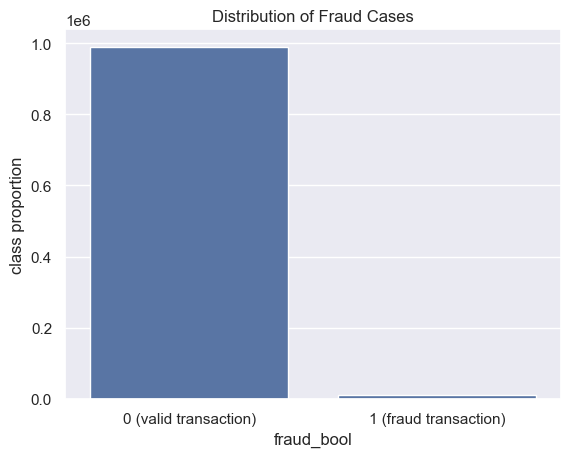

In [7]:
fraud_distribution = imputed_df['fraud_bool'].value_counts(normalize=True)
print("Normalized Fraud Distribution:")
print(fraud_distribution)

# plt.figure(figsize=(8, 6))
g = sb.countplot(x='fraud_bool', data=imputed_df)
g.set_xticks([0,1], ["0 (valid transaction)", "1 (fraud transaction)"])
plt.ylabel("class proportion")
plt.title('Distribution of Fraud Cases')
plt.show()

As in most fraud detection problems, we have high imbalance between the fraudulent & non fraudulent transactions.
This is to take into account when training a model, as class imbalance needs to be addressed.


### features distribution

In [207]:
print(imputed_df.columns)

Index(['fraud_bool', 'income', 'name_email_similarity',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'month',
       'prev_address_months_count_is_missing',
       'intended_balcon_amount_is_missing', 'bank_months_count_is_missing'],
      dtype='object')


Let's split the features by type :

In [8]:
categorical_features = imputed_df.select_dtypes(include=['object']).columns
booleans_features = [feat for feat in imputed_df.columns if imputed_df[feat].nunique()==2]
numeric_features = [col for col in imputed_df.select_dtypes(include=['int64', 'float64']).columns if col not in booleans_features]



# dropping fraud_bool from our boolean list
booleans_features.remove('fraud_bool')

print("numeric:", numeric_features)

print("categorical:", categorical_features)

print('booleans', booleans_features)

numeric: ['income', 'name_email_similarity', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'device_distinct_emails_8w', 'month']
categorical: Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')
booleans ['email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source', 'keep_alive_session', 'prev_address_months_count_is_missing', 'intended_balcon_amount_is_missing', 'bank_months_count_is_missing']


Let's check for distribution for both categoric & numeric features :

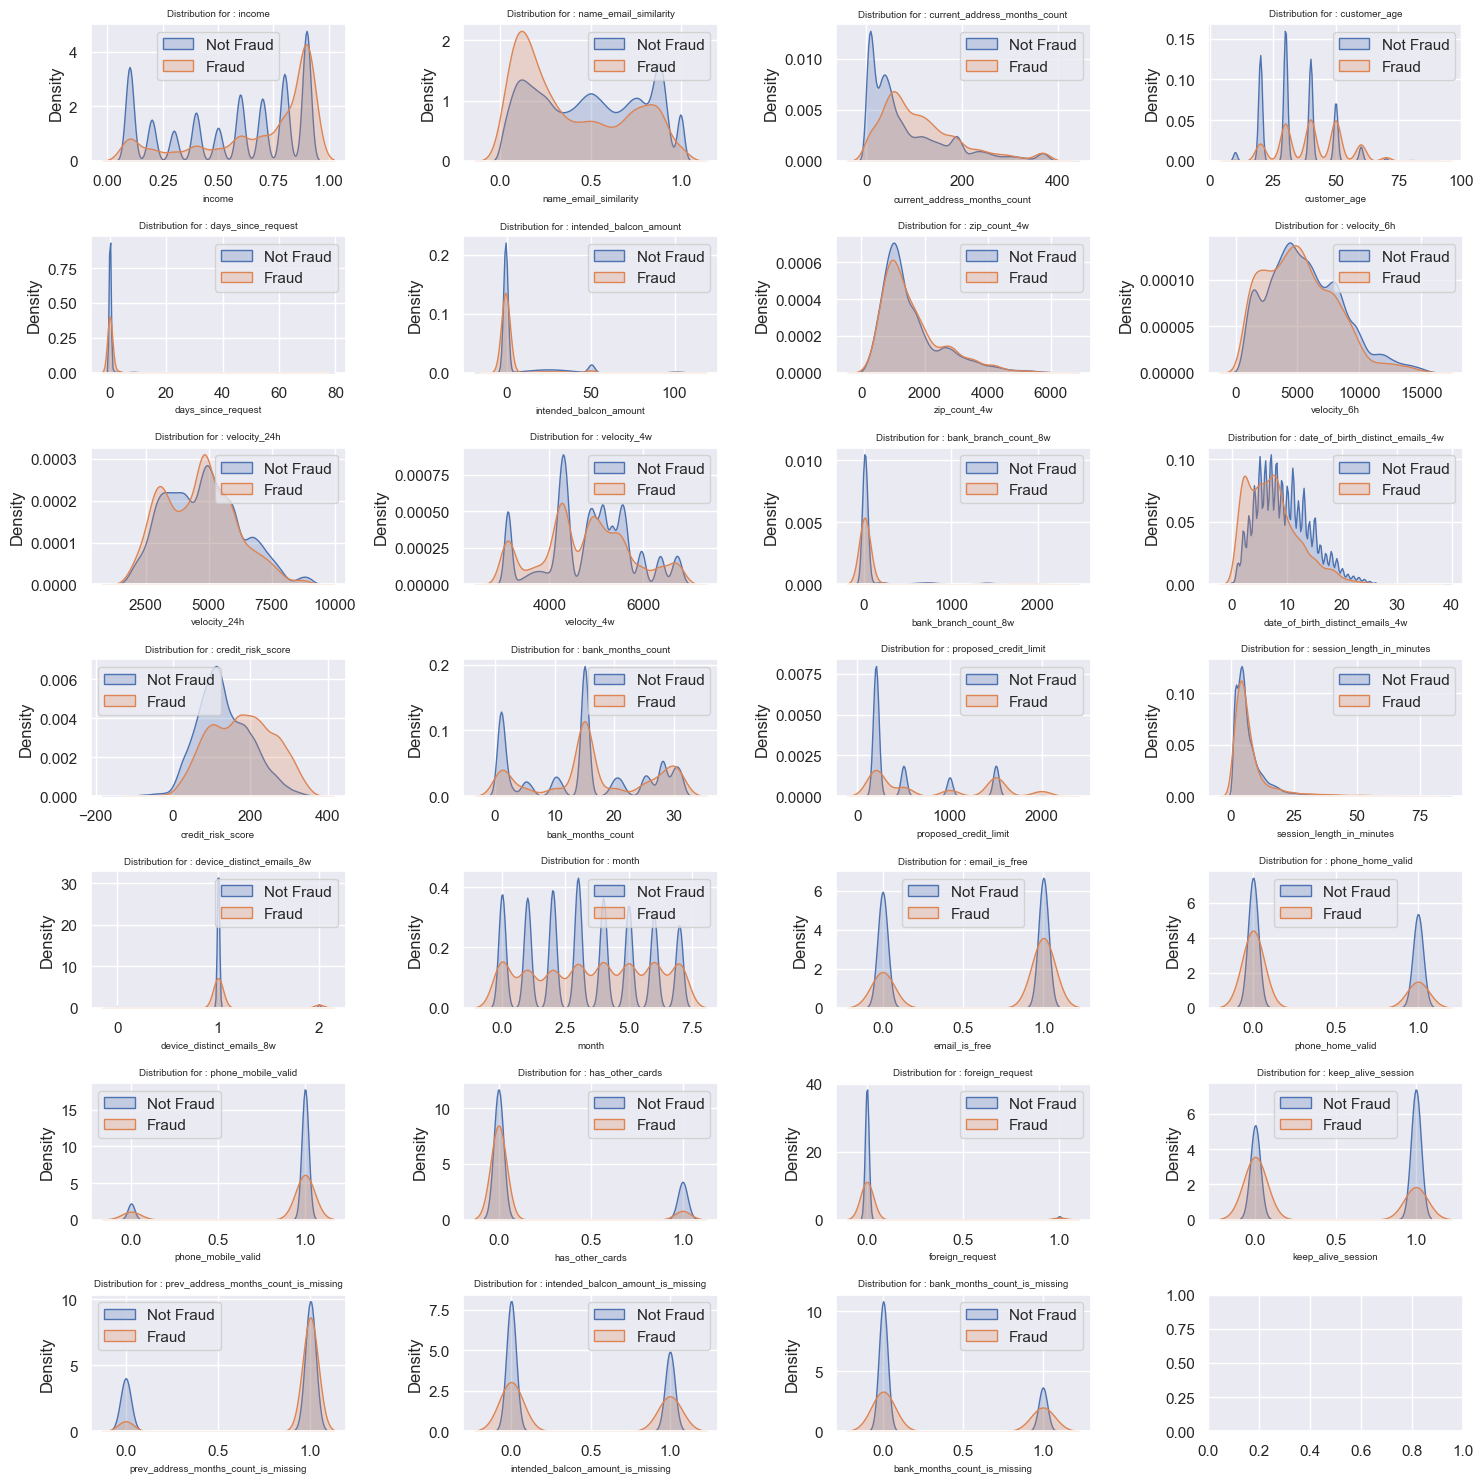

In [213]:
fig, axes = plt.subplots(7,4, figsize=(15,15))
axes = axes.flatten()
for i, feat in enumerate(numeric_features+booleans_features):

    sb.kdeplot(data=imputed_df[imputed_df['fraud_bool'] == 0][feat], fill=True, ax=axes[i], label='Not Fraud')
    sb.kdeplot(data=imputed_df[imputed_df['fraud_bool'] == 1][feat], fill=True, ax=axes[i], label='Fraud')

    axes[i].set_title("Distribution for : {}".format(feat), fontsize=7)
    axes[i].set_xlabel(feat, fontsize=7)
    axes[i].legend()

plt.tight_layout()
plt.show()



Comparison of data distribution for fraud vs non-fraud transactions :

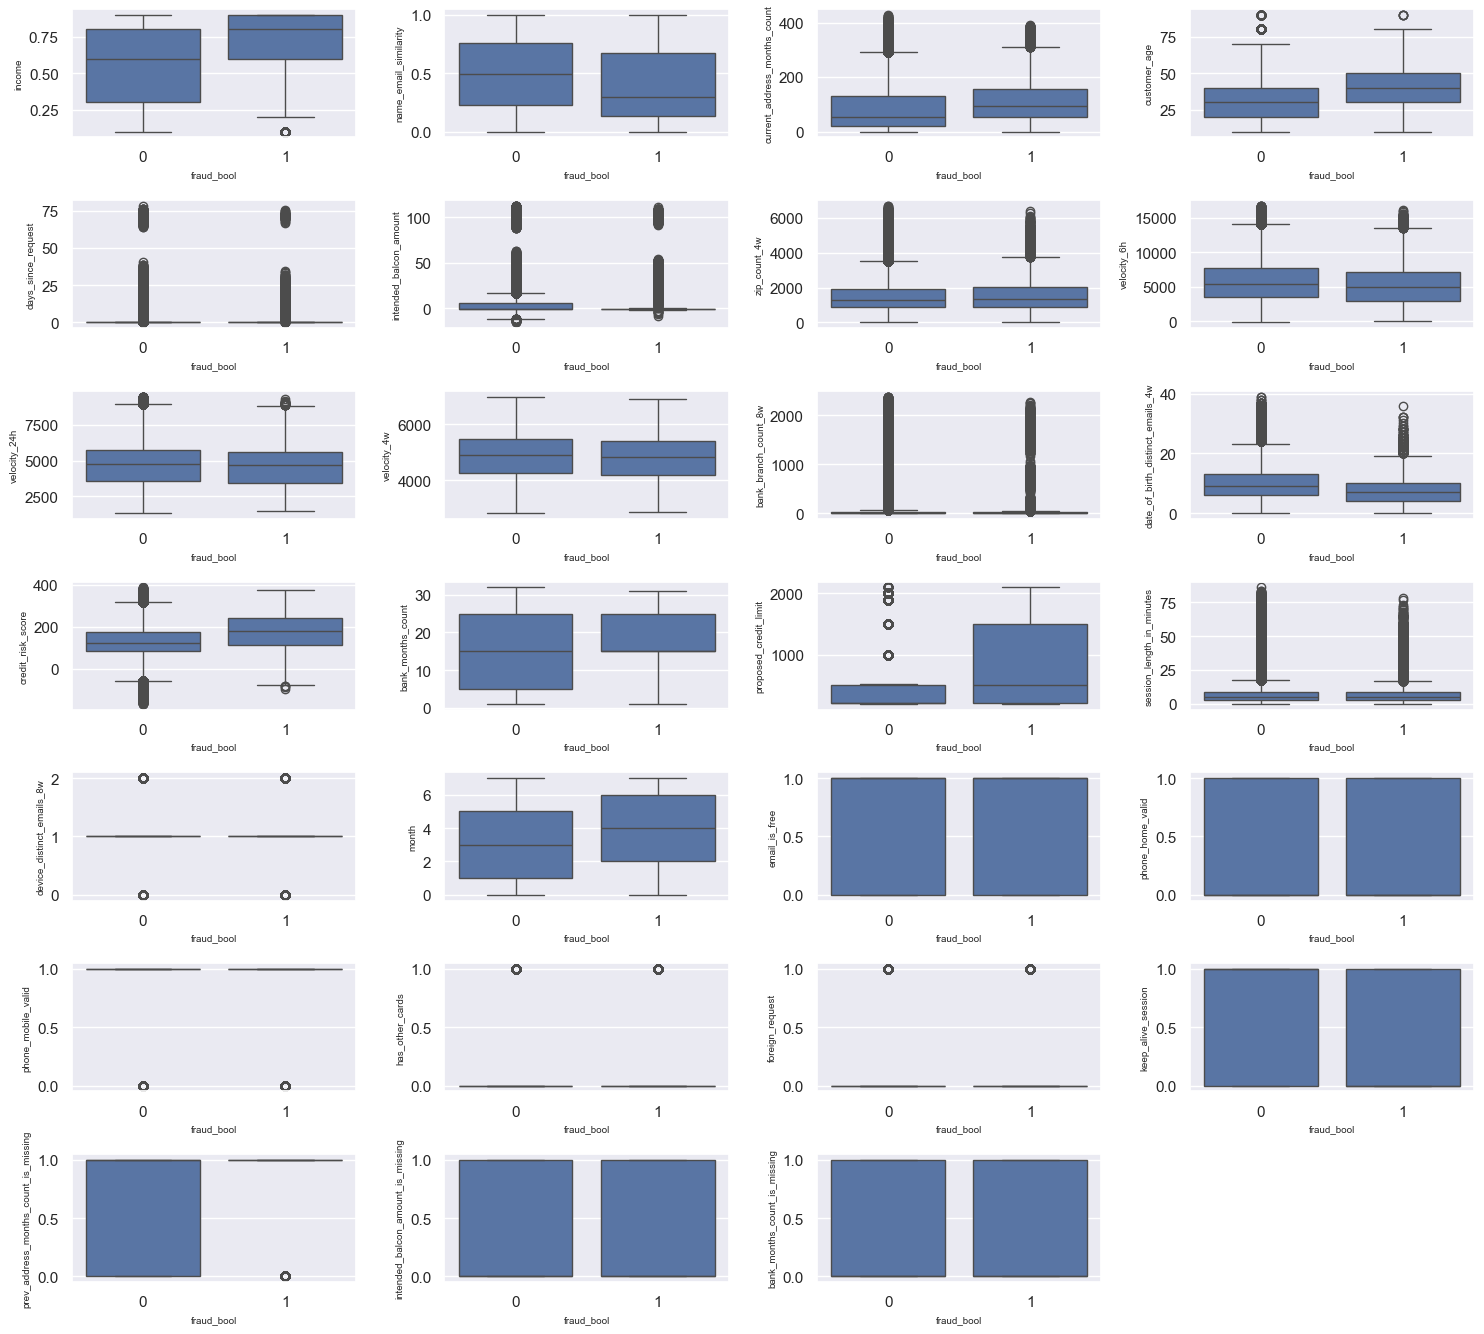

In [214]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(numeric_features + booleans_features):
    ax = plt.subplot(8, 4, i+1)
    sb.boxplot(x='fraud_bool', y=feature, data=imputed_df)
    ax.set_xlabel("fraud_bool", fontsize=7)
    ax.set_ylabel(feature, fontsize=7)
plt.tight_layout()
plt.show()

Several features have many outliers, we might need to process these datapoints in order to improve our models.

### Chi-Squared test on categorical features
To evaluate the relationship between cat features & the target variable

In [220]:
from scipy.stats import chi2_contingency

for feat in categorical_features:
    contingency_table = pd.crosstab(imputed_df['fraud_bool'], imputed_df[feat])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print("{}: chi2 = {:.2f}, p-value = {:.4f}".format(feat, chi2, p_value))

payment_type: chi2 = 1528.34, p-value = 0.0000
employment_status: chi2 = 1572.50, p-value = 0.0000
housing_status: chi2 = 13202.79, p-value = 0.0000
source: chi2 = 14.94, p-value = 0.0001
device_os: chi2 = 6478.95, p-value = 0.0000


Every p-value is < 0.05, which confirms these features are linked to our label.

_note: "source" has a low chi2 number compared to the other features, which could be explained by the fact that this feature is clearly imbalanced between its two categories. As a result, we might not use it for our detection models_



In [9]:
booleans_features.remove('source')
imputed_df = imputed_df.drop(columns='source')


### Multicolinearity test on numeric features


We can have a look at the linear relationship between features in order to reduce dimensionality. 


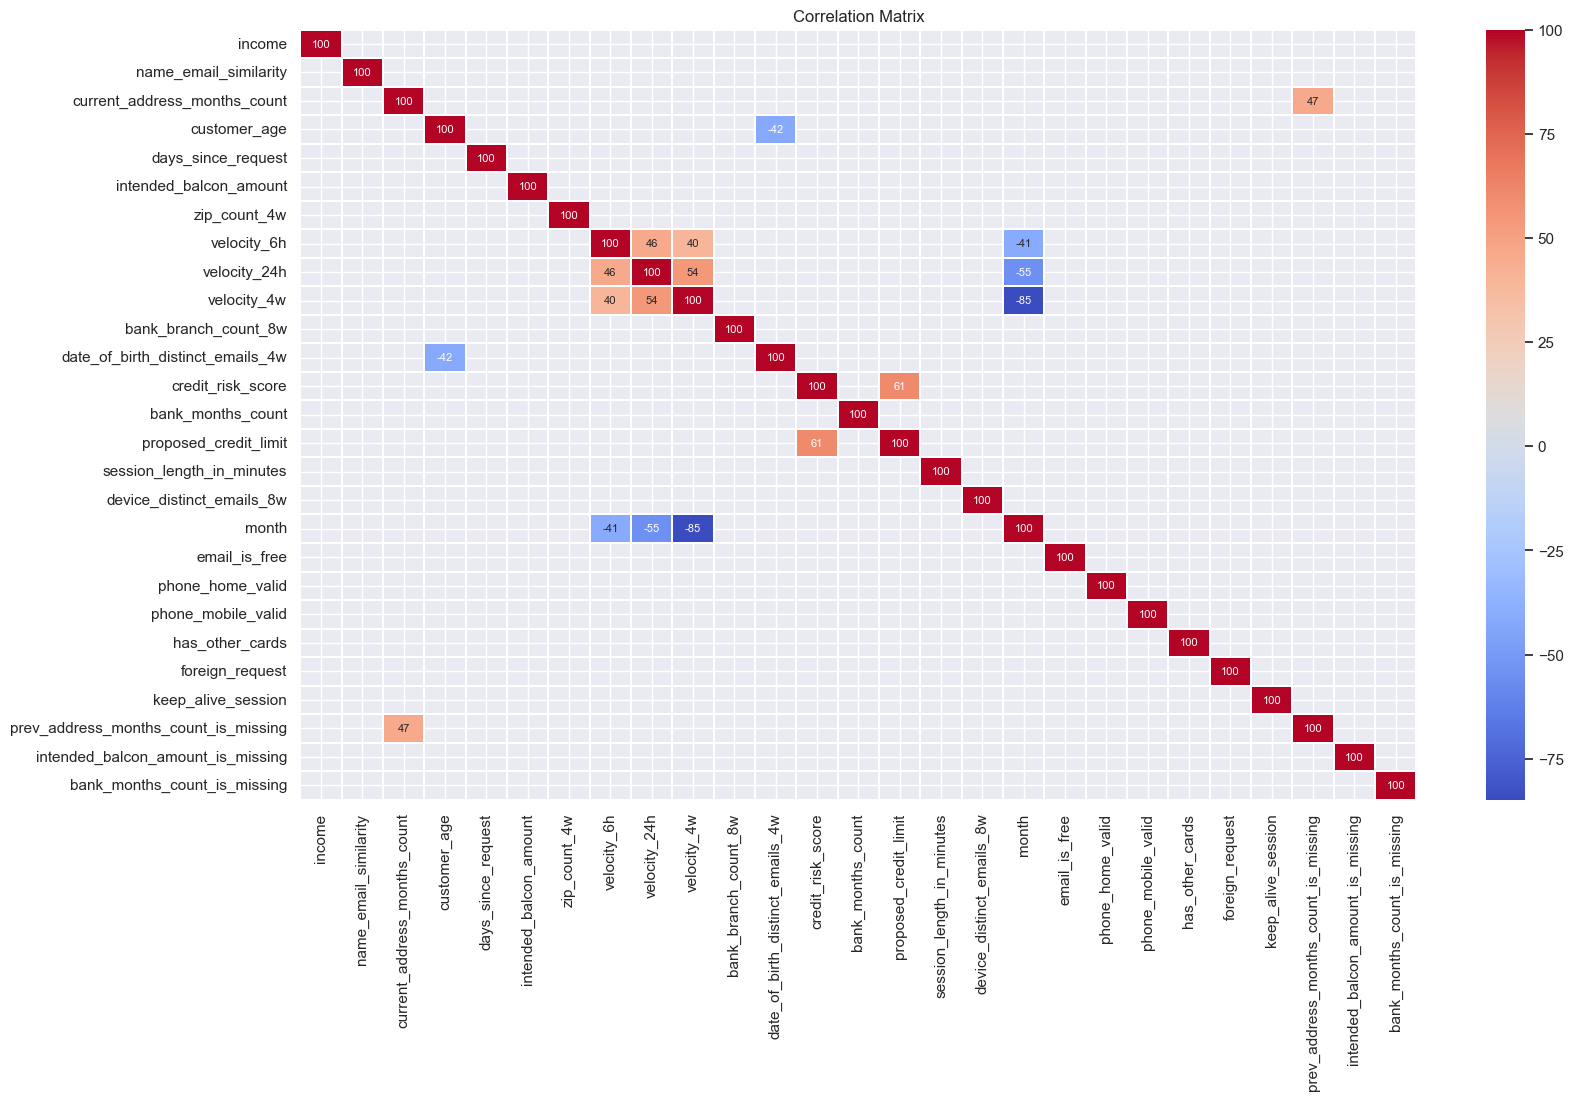

In [227]:
corr = imputed_df[numeric_features + booleans_features].corr()

# Show only corr up to 0.4 
mask = corr.abs() <= 0.4
corr_masked = corr.mask(mask)
corr_masked = corr_masked.map(lambda x: x*100)

fig, ax = plt.subplots(figsize=(18, 10))
sb.heatmap(corr_masked, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=0.1, cmap="coolwarm", ax=ax, annot=True, fmt='.0f', annot_kws={"size": 8})
ax.set_title('Correlation Matrix')

# plt.savefig("corr.png")
plt.show()

"month" & "velocity_4w"  have a high linear relation (which makes sense since velocity_4w is a temporal feature), we will drop them.

In [10]:
imputed_df = imputed_df.drop(columns=["velocity_4w", 'month'])
numeric_features.remove('velocity_4w')
numeric_features.remove('month')

## Data exploration conclusion

These analyses are useful for several reasons : 
* The data distribution between fraud vs non-fraud transactions is different for some features; which might make these predictors essential for prediction
* Some features seem to contain extreme outliers, removing these might have a positive impact on the precision of our models
* the Chi-Squared test on categorical features can help us decide which feature is useful or not for our models
* the "month" column is a temporal feature and could be sued for dataset splitting for example, but we won't be using it. 
 



___


# Methods selection 
When working on a fraud detection problem, we can study it under different scopes. Here are the methods I'll use to try and solve this problem : 
* supervised learning methods : we can consider building a classification model : the goal would be to use the "fraud_bool" column as a training label
* unsupervised learning methods : we could also consider this problem as an outlier detection problem, which can be efficient for high dimensionality & high imbalance in the target label

To compare models, we will use cross validation to have a more accurate estimation of the performance of the models.
Even if we resample the majority class to have a more balanced ratio, we'll use stratified Kfold instead of regular Kfold.

## Model evaluation

Accuracy cannot be used in fraud detection models ass we have a highly imbalanced dataset.
We will use AUC (Area Under Curve) score to compare models. 

## Model 1 : XGBoost
We first start with a supervised training model. We will need to address class imbalance in order for the model to be able to learn the anomaly pattern. 

### Data processing

#### Train test split
We need to create a training & a testing dataset and also encode the categorical features.

In [11]:
# data splitting for training purposes, making sure we keep the fraud ratio in both datasets
X = imputed_df.drop(columns = 'fraud_bool')
y = imputed_df['fraud_bool']

X_processed = X.copy()
X_processed = pd.get_dummies(X_processed)

scaler = StandardScaler()

X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)



print(y_train.value_counts()/len(y_train))

print(y_test.value_counts()/len(y_test))

print("Train dataset proportion :{}%\n".format(100*round(len(X_train)/len(X), 3)))

# remaining features 

# print(numeric_features)
# print(categorical_features)
# print(booleans_features)
X_train.head(1)




fraud_bool
0    0.988971
1    0.011029
Name: count, dtype: float64
fraud_bool
0    0.98897
1    0.01103
Name: count, dtype: float64
Train dataset proportion :80.0%



,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,bank_branch_count_8w,...,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
39111,0.472905,-0.913039,-0.269892,1.356328,-0.185993,2.076112,-0.266261,2.358968,1.114709,-0.385884,...,True,False,False,False,False,True,False,False,False,False


#### Data resampling to tackle class imbalance
To train a supervised model, we need to adapt the training dataset to a better ratio between fraud & non fraud transaction, as there is high imbalance in the base dataset.

We will use an undersampling method on the non fraud datapoints to keep the maximum of fraud datapoints.

In [12]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy=0.1)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [31]:
y_train_resampled.value_counts()

fraud_bool
0    88230
1     8823
Name: count, dtype: int64

The dataset is now more balanced, I kept a 0.1 proportion btween the two classes to keep some non fraudulent operations.

### Model training & cross validation


In [28]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# Define the number of folds
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize lists to store the scores for each fold
precisions = []
recalls = []
f1_scores = []
auc_scores = []

X_train_resampled.reset_index(drop=True)
y_train_resampled.reset_index(drop=True)

for (train_index, val_index) in skf.split(X_train_resampled, y_train_resampled):

    X_train_fold, X_val_index = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
    
    xgb_clf = XGBClassifier(random_state=42)
    xgb_clf.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = xgb_clf.predict(X_val_index)
    y_pred_proba = xgb_clf.predict_proba(X_val_index)[:, 1]
    
    # metrics
    precisions.append(precision_score(y_val_fold, y_pred_fold))
    recalls.append(recall_score(y_val_fold, y_pred_fold))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold))
    auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba))
    
    print("AUC score : {:.4f}".format(roc_auc_score(y_val_fold, y_pred_proba)))

# Check method performance 
print("\nCross-validation results:")
print("Avg precision: {:.4f}".format(np.mean(precisions)))
print("Avg recall: {:.4f}".format(np.mean(recalls)))
print("Avg F1-score: {:.4f}".format(np.mean(f1_scores)))
print("AVG AUC-ROC score: {:.4f}".format(np.mean(auc_scores)))

AUC score : 0.8748
AUC score : 0.8822
AUC score : 0.8770
AUC score : 0.8756
AUC score : 0.8788

Cross-validation results:
Avg precision: 0.8015
Avg recall: 0.7990
Avg F1-score: 0.8002
AVG AUC-ROC score: 0.8777


### Final model test

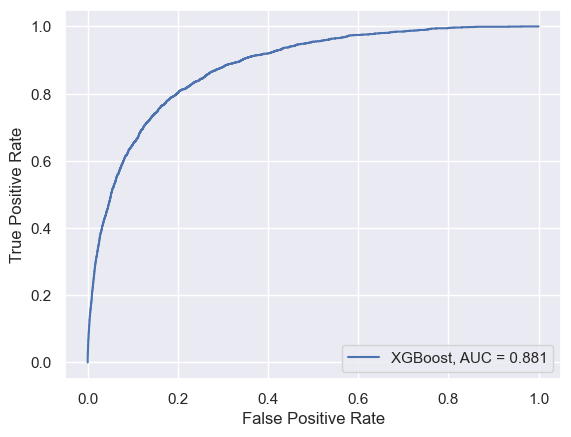

In [29]:
xgb_clf_test = XGBClassifier(random_state=42)
xgb_clf_test.fit(X_train_resampled, y_train_resampled)

xgb_pred = xgb_clf_test.predict(X_test)
xgb_proba = xgb_clf_test.predict_proba(X_test)

# model evaluation
auc = roc_auc_score(y_true=y_test, y_score=xgb_proba[:,1])

fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:,1])

plt.figure()
plt.plot(fpr,tpr,label="XGBoost, AUC = {:.3f}".format((auc)))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## Experience conclusion

The model successfully detects fraudulent operations but could still be improved as the AUC is only of 88%. 
The next steps to improve the precision of the model would be :
* more advanced feature selection
* hyperparameters optimization, as I didn't explore any parameter tuning.

## Model 2 : Outlier detection
The second method I'll be testing is an unsupervised method of outlier detection, to see if it would perform better than a supervised method.
I will be testing an IsolationForest model, using the dataset's data distribution as contamination_factor.

If this method can successfully identify outliers, it could be useful as it would mean not needing labelised data to detect fraudulent operations.

### Data processing 2
Due to the nature of its method, we can use unscaled data to train our isolation forest model. We will therefore only train test split the processed dataset to be able to evaluate our model. 

In [65]:
X2 = imputed_df.drop(columns = 'fraud_bool')
y2 = imputed_df['fraud_bool']

X_processed2 = X2.copy()
X_processed2 = pd.get_dummies(X_processed2)
scaler = StandardScaler()

X_processed2 = scaler.fit_transform(X_processed2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_processed2, y2, test_size=0.2, random_state=42, stratify=y2)


### Model training 2

In [66]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize lists to store the scores for each fold
precisions = []
recalls = []
f1_scores = []
auc_scores = []


for (train_index, val_index) in skf.split(X_train2, y_train2):

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    if_clf = IsolationForest(contamination=fraud_distribution[1], random_state=42, n_estimators=250, n_jobs=-1)
    if_clf.fit(X_train_fold)
    
    y_pred_fold = if_clf.predict(X_val_fold)
    y_pred_fold = (y_pred_fold == -1).astype(int)
    y_pred_proba = -if_clf.decision_function(X_val_fold)
    
    # metrics
    precisions.append(precision_score(y_val_fold, y_pred_fold))
    recalls.append(recall_score(y_val_fold, y_pred_fold))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold))
    auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba))
    
    print("AUC score : {:.4f}".format(roc_auc_score(y_val_fold, y_pred_proba)))

# Check method performance 
print("\nCross-validation results:")
print("Avg precision: {:.4f}".format(np.mean(precisions)))
print("Avg recall: {:.4f}".format(np.mean(recalls)))
print("Avg F1-score: {:.4f}".format(np.mean(f1_scores)))
print("AVG AUC-ROC score: {:.4f}".format(np.mean(auc_scores)))

# IF = IsolationForest(contamination=float(fraud_distribution[1]), random_state=42, n_estimators=250, n_jobs=-1)

# IF.fit(X_train2)

# if_scores = -IF.decision_function(X_test2) # we negate the scores as 'decision_function' returns negatives scores for outliers.
# if_pred = IF.predict(X_test2)
# if_pred = (if_pred == -1).astype(int)  # Convert anomalies (-1) to fraud label 


AUC score : 0.5645
AUC score : 0.5646
AUC score : 0.5826
AUC score : 0.5641
AUC score : 0.5510

Cross-validation results:
Avg precision: 0.0251
Avg recall: 0.0250
Avg F1-score: 0.0250
AVG AUC-ROC score: 0.5654


The performance metrics of this model are really poor, the chosen algorithm struggles to succefully detect outliers with the training data used.
This could be explained by the fact that the anomalies cannot be distinguished using the selected features (I used several boolean feature for example), and that anomalies are not differentiable to normal datapoints (at least when using binary decision trees as an estimator).


### Final model testing 2

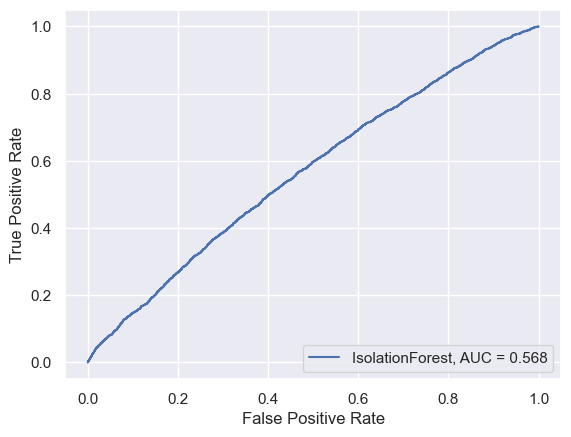

In [62]:
isof_test = IsolationForest(random_state=42, contamination=fraud_distribution[1], n_estimators=250, n_jobs=-1)

isof_test.fit(X_train)

if_pred = isof_test.predict(X_test)
anomaly_scores = -isof_test.decision_function(X_test)

# model evaluation
auc = roc_auc_score(y_true=y_test, y_score=anomaly_scores)

fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)

plt.figure()
plt.plot(fpr,tpr,label="IsolationForest, AUC = {:.3f}".format((auc)))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=4)
plt.show()


### Experience conclusion 2

The isolation forest algorithm doesn't seem to be a good fit for outlier detection on this specific dataset. A deeper study should be done in order to identify the reason of the poor predictions, as it only performs as good as a random predictor (AUC of 57%).
Better results could most likely be obtained by working on different features than the ones presented here, combined to more advanced feature selection.
I didn't have more time to explore other paths using this method, but I am curious to see if we can successfully build an outlier detection model for this topic, using other unsupervised training method such as Local outlier factor or SVM. 


# Conclusion
We studied two different methods to tackle this fraud detection problem. 
Supervised learning seems to be quite easily applicable, better performance could probably be obtained by tuning the hyperparameters & working on data processing deeper, and exploring other methods such as deep learning classification, which might be able to identify non linear correlation between features & fraud.
When I started working on this subject, I thought that anomaly detection algorithms would be performing better than we have seem in the previous section.
The failure to train the model properly shows the importance of analyzing the data distribution and of choosing the right features before training an algorithm. 

Unfortunately, I didn't have time to work on the bonus question of explainibility.
